In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
#import rdkit
#from rdkit import Chem
#from pubchempy import *

In [ ]:
#Let's calculate the Tanimoto Similarity for all pairwise, this step is performed in the cluster
#under the name CTD_chem_smile_similarity.py
#For more info into the fingerprint, you can find it here
#https://stackoverflow.com/questions/67811388/how-can-i-interpret-the-features-obtained-from-chem-rdkfingerprintmol
#https://www.daylight.com/dayhtml/doc/theory/theory.finger.html
#https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

import pandas as pd
import networkx as nx
import numpy as np
import pickle as pk
import itertools as it
import rdkit
from pubchempy import *
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols

def calculate_tanimoto_coefficient(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is not None and mol2 is not None:
        fp1 = FingerprintMols.FingerprintMol(mol1)  # Get the fingerprint of the first molecule
        fp2 = FingerprintMols.FingerprintMol(mol2)  # Get the fingerprint of the second molecule
        tanimoto_coefficient = DataStructs.TanimotoSimilarity(fp1, fp2)
        return tanimoto_coefficient
    return None

#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

#Let's import the Chemical Vocabolary
chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)

#Let's convert the chemical names from CTD to smiles
chem_name_set=set(chem_homo['# ChemicalName'])
chem_smile_list=[]
chem_name_smile_dict={}
for chem in chem_name_set:
    try:
        for compound in get_compounds(chem, 'name'):
            smile=compound.isomeric_smiles
            chem_smile_list.append(smile)
            chem_name_smile_dict[smile]=chem
    except:
        try:
            syn_list = chem_vocabolary[chem_vocabolary['# ChemicalName']==chem]['Synonyms'].values[0].split("|")
            for syn in syn_list:
                try:
                    for compound in get_compounds(syn, 'name'):
                        smile=compound.isomeric_smiles
                        chem_smile_list.append(smile)
                        chem_name_smile_dict[smile]=chem
                except:
                    pass
        except:        
            pass
with open('output/chem_name_smile_dict.pickle', 'wb') as handle:
    pk.dump(chem_name_smile_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

#Let's define a dictionary that will convert the chemical name in chemical ID
chem_name_id_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_name_id_conversion[v["# ChemicalName"]] = v["ChemicalID"]

#Let's invert the chem_name_smile_dict
def invert_dict(d):
    inverted_dict = {}
    for key, value in d.items():
        if value not in inverted_dict:
            inverted_dict[value] = [key]
        else:
            inverted_dict[value].append(key)
    return inverted_dict

chem_name_smile_dict_inv=invert_dict(chem_name_smile_dict)

#Let's convert the chem name into chem ids
chem_id_smile_dict={}
for chem_name,smile_list in chem_name_smile_dict_inv.items():
    chem_id_smile_dict[chem_name_id_conversion[chem_name]]=smile_list

with open('output/chem_id_smile_dict.pickle', 'wb') as handle:
    pk.dump(chem_id_smile_dict, handle, protocol=pk.HIGHEST_PROTOCOL)



In [78]:
#Let's import the results

with open('output/chem_name_smile_dict.pickle', 'rb') as handle:
    chem_name_smile_dict = pk.load(handle)


with open('output/chem_id_smile_dict.pickle', 'rb') as handle:
    chem_id_smile_dict = pk.load(handle)


In [110]:
missing_chem = []
for chem in chem_name_set:
    if chem not in set(chem_name_smile_dict.values()):
        missing_chem.append(chem)
print(len(set(missing_chem)))

2129


In [116]:
missing_for_real_chem = []
for chem in missing_chem:
    try:
        syn_list = chem_vocabolary[chem_vocabolary['# ChemicalName']==chem]['Synonyms'].values[0].split("|")
        for syn in syn_list:
            try:
                for compound in get_compounds(syn, 'name'):
                    smile=compound.isomeric_smiles
                    chem_name_smile_dict[smile]=chem
            except:
                missing_for_real_chem.append(chem)
    except:
        missing_for_real_chem.append(chem)


In [120]:

chem_name_smile_dict_inv=invert_dict(chem_name_smile_dict)

In [124]:
#Let's convert the chem name into chem ids
chem_id_smile_dict={}
for chem_name,smile_list in chem_name_smile_dict_inv.items():
    chem_id_smile_dict[chem_name_id_conversion[chem_name]]=smile_list
    
len(chem_id_smile_dict)

8290

In [125]:
with open('output/chem_id_smile_dict_final.pickle', 'wb') as handle:
    pk.dump(chem_id_smile_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

with open('output/chem_name_smile_dict_final.pickle', 'wb') as handle:
    pk.dump(chem_name_smile_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [ ]:
chem_id_list=list(chem_id_smile_dict.keys())
chem_id_pairwise=list(it.combinations(chem_id_list,2))

chem_tanimoto_dict={}
for chem_id_pair in chem_id_pairwise:
    try:
        taninomoto_coeff=calculate_tanimoto_coefficient(chem_id_smile_dict[chem_id_pair[0]][0],chem_id_smile_dict[chem_id_pair[1]][0])
        chem_tanimoto_dict[chem_id_pair]=taninomoto_coeff
    except:
        pass

with open('intermediate/chem_tanimoto_dict.pickle', 'wb') as handle:
    pk.dump(chem_tanimoto_dict, handle, protocol=pk.HIGHEST_PROTOCOL)

In [2]:

with open('intermediate/chem_tanimoto_dict.pickle', 'rb') as handle:
    chem_tanimoto_dict = pk.load(handle)


In [127]:
len(chem_tanimoto_dict)

34357905

In [131]:
8290*8289/2

34357905.0

In [ ]:
#Let's calculate the Resnik Similarity across all chemical pairwise
#In this step, we will calculate also the Jaccard Index between the set overlap of the two perturbed geneset
#for each chemical exposure pairs
#This cell is performed in the cluster with the following script: CTD_Resnik

#Let's import the ontology from CTD
chem_vocabolary = pd.read_csv("input/CTD/CTD_chemicals_cleaned.txt",delimiter= '\t',
           skipinitialspace=True)

#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        
#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass
        
#This function calculates the Jaccard Index between two lists
def overlap_jaccard(list1,list2):
    intersction_term= len(set(list1) & set(list2))
    denominator = len(set(list1).union(set(list2)))
    overlap_jaccard_coeff = intersction_term/denominator
    return overlap_jaccard_coeff

#This function is the first step for the resnik score calculation
def precalc_lower_bounds(G):
    """Pre-calculate the number of lower bounds of the graph nodes
    """
    G.lower_bounds = Counter()
    for n in G:
        G.lower_bounds[n] += 1
        for ans in nx.ancestors(G, n):
            G.lower_bounds[ans] += 1
   # G.descriptors.add("Pre-calculated lower bounds")
#This function is the second step for the resnik score calculation
def information_content(G, term):
    """Information content
    Args:
        G(Ontology Graph): Ontology graph object
        term(str): ontolgy term
    Returns:
        str - Information content
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term not in G.lower_bounds:
        raise exception.PGSSLookupError(f"Missing term: {term}")
    freq = G.lower_bounds[term] / len(G)
    return round(-1 * math.log2(freq), 3)

#This function is the third step for the resnik score calculation
def lowest_common_ancestor(G, term1, term2):
    """Naive implementation of lowest common ancestor (LCA)
    Args:
        G(GoGraph): Graph object
        term1(str): Ontology term 1
        term2(str): Ontology term 2
    Returns:
        str - Lowest common ancestor term
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in Ontology Graph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    if term1 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term1}")
    if term2 not in G:
        raise exception.PGSSLookupError(f"Missing term: {term2}")
    lb1 = nx.ancestors(G, term1) | {term1}
    lb2 = nx.ancestors(G, term2) | {term2}
    common_ans = lb1 & lb2
    if not common_ans:
        return
    return min(common_ans, key=lambda x: G.lower_bounds[x])
import math
#This function would return the resnik score between two terms
def resnik(G, term1, term2):
    """Semantic similarity based on Resnik method
    Args:
        G(GoGraph): Ontology graph object
        term1(str): term 1
        term2(str): term 2
    Returns:
        float - Resnik similarity value (Information content of LCA)
        or None if the terms have no common ancestors
    Raises:
        PGSSLookupError: The term was not found in GoGraph
        PGSSInvalidOperation: see `pygosemsim.similarity.precalc_lower_bounds`
    """
    mica = lowest_common_ancestor(G, term1, term2)
    if mica is not None:
        return information_content(G, mica)
    
chem_voc_dict = {}
for i,v in chem_vocabolary.iterrows():
    try:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"].split("|")
    except:
        chem_voc_dict[v["ChemicalID"]] = v["ParentIDs"]
from collections.abc import Mapping
# Empty directed graph
G = nx.DiGraph()
for k in chem_voc_dict.keys():
    try:
        for v in chem_voc_dict[k]:
            G.add_edge(k, v)
    except:
        G.add_edge(k,"D")

G_down = nx.DiGraph.reverse(G)
precalc_lower_bounds(G_down)

parenthood_similarity_score_pairs_dictio = {}
parenthood_overlap_pairs_dictio = {}

wo_parenthood_similarity_score_pairs_dictio = {}
wo_parenthood_overlap_pairs_dictio = {}

pairwise_list = list(it.combinations(chem_gene_cleaned.keys(), 2))
for i,j in pairwise_list:
    if i not in nx.descendants(G_down,j) and j not in nx.descendants(G_down,i):           #I exclude direct parents-children exposures
        wo_parenthood_similarity_score_pairs_dictio[i,j] = round(resnik(G_down, i, j),3)
        geneset_1=chem_gene_cleaned[i]
        geneset_2=chem_gene_cleaned[j]
        wo_parenthood_overlap_pairs_dictio[i,j] = round(overlap_jaccard(geneset_1,geneset_2),3)
    else:
        parenthood_similarity_score_pairs_dictio[i,j] = round(resnik(G_down, i, j),3)
        geneset_1=chem_gene_cleaned[i]
        geneset_2=chem_gene_cleaned[j]
        parenthood_overlap_pairs_dictio[i,j]=round(overlap_jaccard(geneset_1,geneset_2),3)


with open('intermediate/wo_parentalhood_resnik.pickle', 'wb') as handle:
    pickle.dump(wo_parenthood_similarity_score_pairs_dictio, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('intermediate/wo_parentalhood_gene_overlap.pickle', 'wb') as handle:
    pickle.dump(wo_parenthood_overlap_pairs_dictio, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('intermediate/parenthood_similarity_score_pairs_dictio.pickle', 'wb') as handle:
    pickle.dump(parenthood_similarity_score_pairs_dictio, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('intermediate/parenthood_overlap_pairs_dictio.pickle', 'wb') as handle:
    pickle.dump(parenthood_overlap_pairs_dictio, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    

In [3]:
#Let's import the resnik score
with open('intermediate/parenthood_similarity_score_pairs_dictio.pickle', 'rb') as handle:
    parenthood_similarity_score_pairs_dictio = pk.load(handle)
with open('intermediate/wo_parentalhood_resnik.pickle', 'rb') as handle:
    wo_parenthood_similarity_score_pairs_dictio = pk.load(handle)

In [4]:
#Let's merge the resnik score without and with parenthood relationships
tot_resnik={**wo_parenthood_similarity_score_pairs_dictio, **parenthood_similarity_score_pairs_dictio}

In [5]:
tanimoto_list=[]
resnik_list=[]
missing_pairs = []

for k,v in chem_tanimoto_dict.items():
    if str(v)!='nan' and str(v)!='inf' and v is not None:
        try:
            try:
                res = tot_resnik[k[0],k[1]]
                if str(res)!='nan' and str(res)!='inf':
                    resnik_list.append(res)
                    tanimoto_list.append(v)
            except:
                res = tot_resnik[k[1],k[0]]
                if str(res)!='nan' and str(res)!='inf':
                    resnik_list.append(res)
                    tanimoto_list.append(v)
        except:
            missing_pairs.append(k)

In [13]:
import scipy  
from scipy import stats

print(scipy.stats.pearsonr(tanimoto_list,resnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tanimoto_list,resnik_list)) # Spearman's rho

PearsonRResult(statistic=0.13954129550173655, pvalue=0.0)
SignificanceResult(statistic=0.09951411795282719, pvalue=0.0)


In [7]:
chem_tanimoto_dict_cl = {}

for k,v in chem_tanimoto_dict.items():
    if v is not None:
        chem_tanimoto_dict_cl[k] = v

In [9]:

# Sort the dictionary (optional, only needed if you want sorted output)
chem_tanimoto_dict_sort = dict(sorted(chem_tanimoto_dict_cl.items(), key=lambda item: item[1]))

# Prepare 10 bins: 0-0.1, 0.1-0.2, ..., 0.9-1.0
bin_edges = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, ..., 1.0
resnik_bins = defaultdict(list)      # dict of lists

# Precompute keys for faster lookup
tot_resnik_get = tot_resnik.get  # for faster access

for chem_pair, tanimoto in chem_tanimoto_dict_sort.items():
    # Determine the bin index (0-9)
    bin_idx = min(int(tanimoto / 0.1), 9)
    
    # Get Resnik value, try both orderings
    resnik_val = tot_resnik_get((chem_pair[0], chem_pair[1]), 
                tot_resnik_get((chem_pair[1], chem_pair[0]), np.nan))
    
    # Append to corresponding bin
    resnik_bins[bin_idx].append(resnik_val)

# Convert to separate lists if you want the old variable names
resnik_list_1 = resnik_bins[0]
resnik_list_2 = resnik_bins[1]
resnik_list_3 = resnik_bins[2]
resnik_list_4 = resnik_bins[3]
resnik_list_5 = resnik_bins[4]
resnik_list_6 = resnik_bins[5]
resnik_list_7 = resnik_bins[6]
resnik_list_8 = resnik_bins[7]
resnik_list_9 = resnik_bins[8]
resnik_list_10 = resnik_bins[9]

In [10]:
#Here, we check the biological cohesiveness of the enrichment terms for each dividing community


column_names = ["Resnik", "Tanimoto"]

resnik_list_tot=[]
group_list=[]
for i in resnik_list_1:
    resnik_list_tot.append(i)
    group_list.append("<10%")
    
for i in resnik_list_2:
    resnik_list_tot.append(i)
    group_list.append("10%-20%")

for i in resnik_list_3:
    resnik_list_tot.append(i)
    group_list.append("20%-30%")
    
for i in resnik_list_4:
    resnik_list_tot.append(i)
    group_list.append("30%-40%")
    
for i in resnik_list_5:
    resnik_list_tot.append(i)
    group_list.append("40%-50%")

for i in resnik_list_6:
    resnik_list_tot.append(i)
    group_list.append("50%-60%")

for i in resnik_list_7:
    resnik_list_tot.append(i)
    group_list.append("60%-70%")
    
for i in resnik_list_8:
    resnik_list_tot.append(i)
    group_list.append("70%-80%")
    
for i in resnik_list_9:
    resnik_list_tot.append(i)
    group_list.append("80%-90%")

for i in resnik_list_10:
    resnik_list_tot.append(i)
    group_list.append("90%-100%")
    
    
Resnik_Tanimoto_df = pd.DataFrame(columns = column_names)
Resnik_Tanimoto_df["Resnik"]=resnik_list_tot
Resnik_Tanimoto_df["Tanimoto"]=group_list

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_64872/997558018.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Tanimoto", y="Resnik", data=Resnik_Tanimoto_df,errorbar='se',


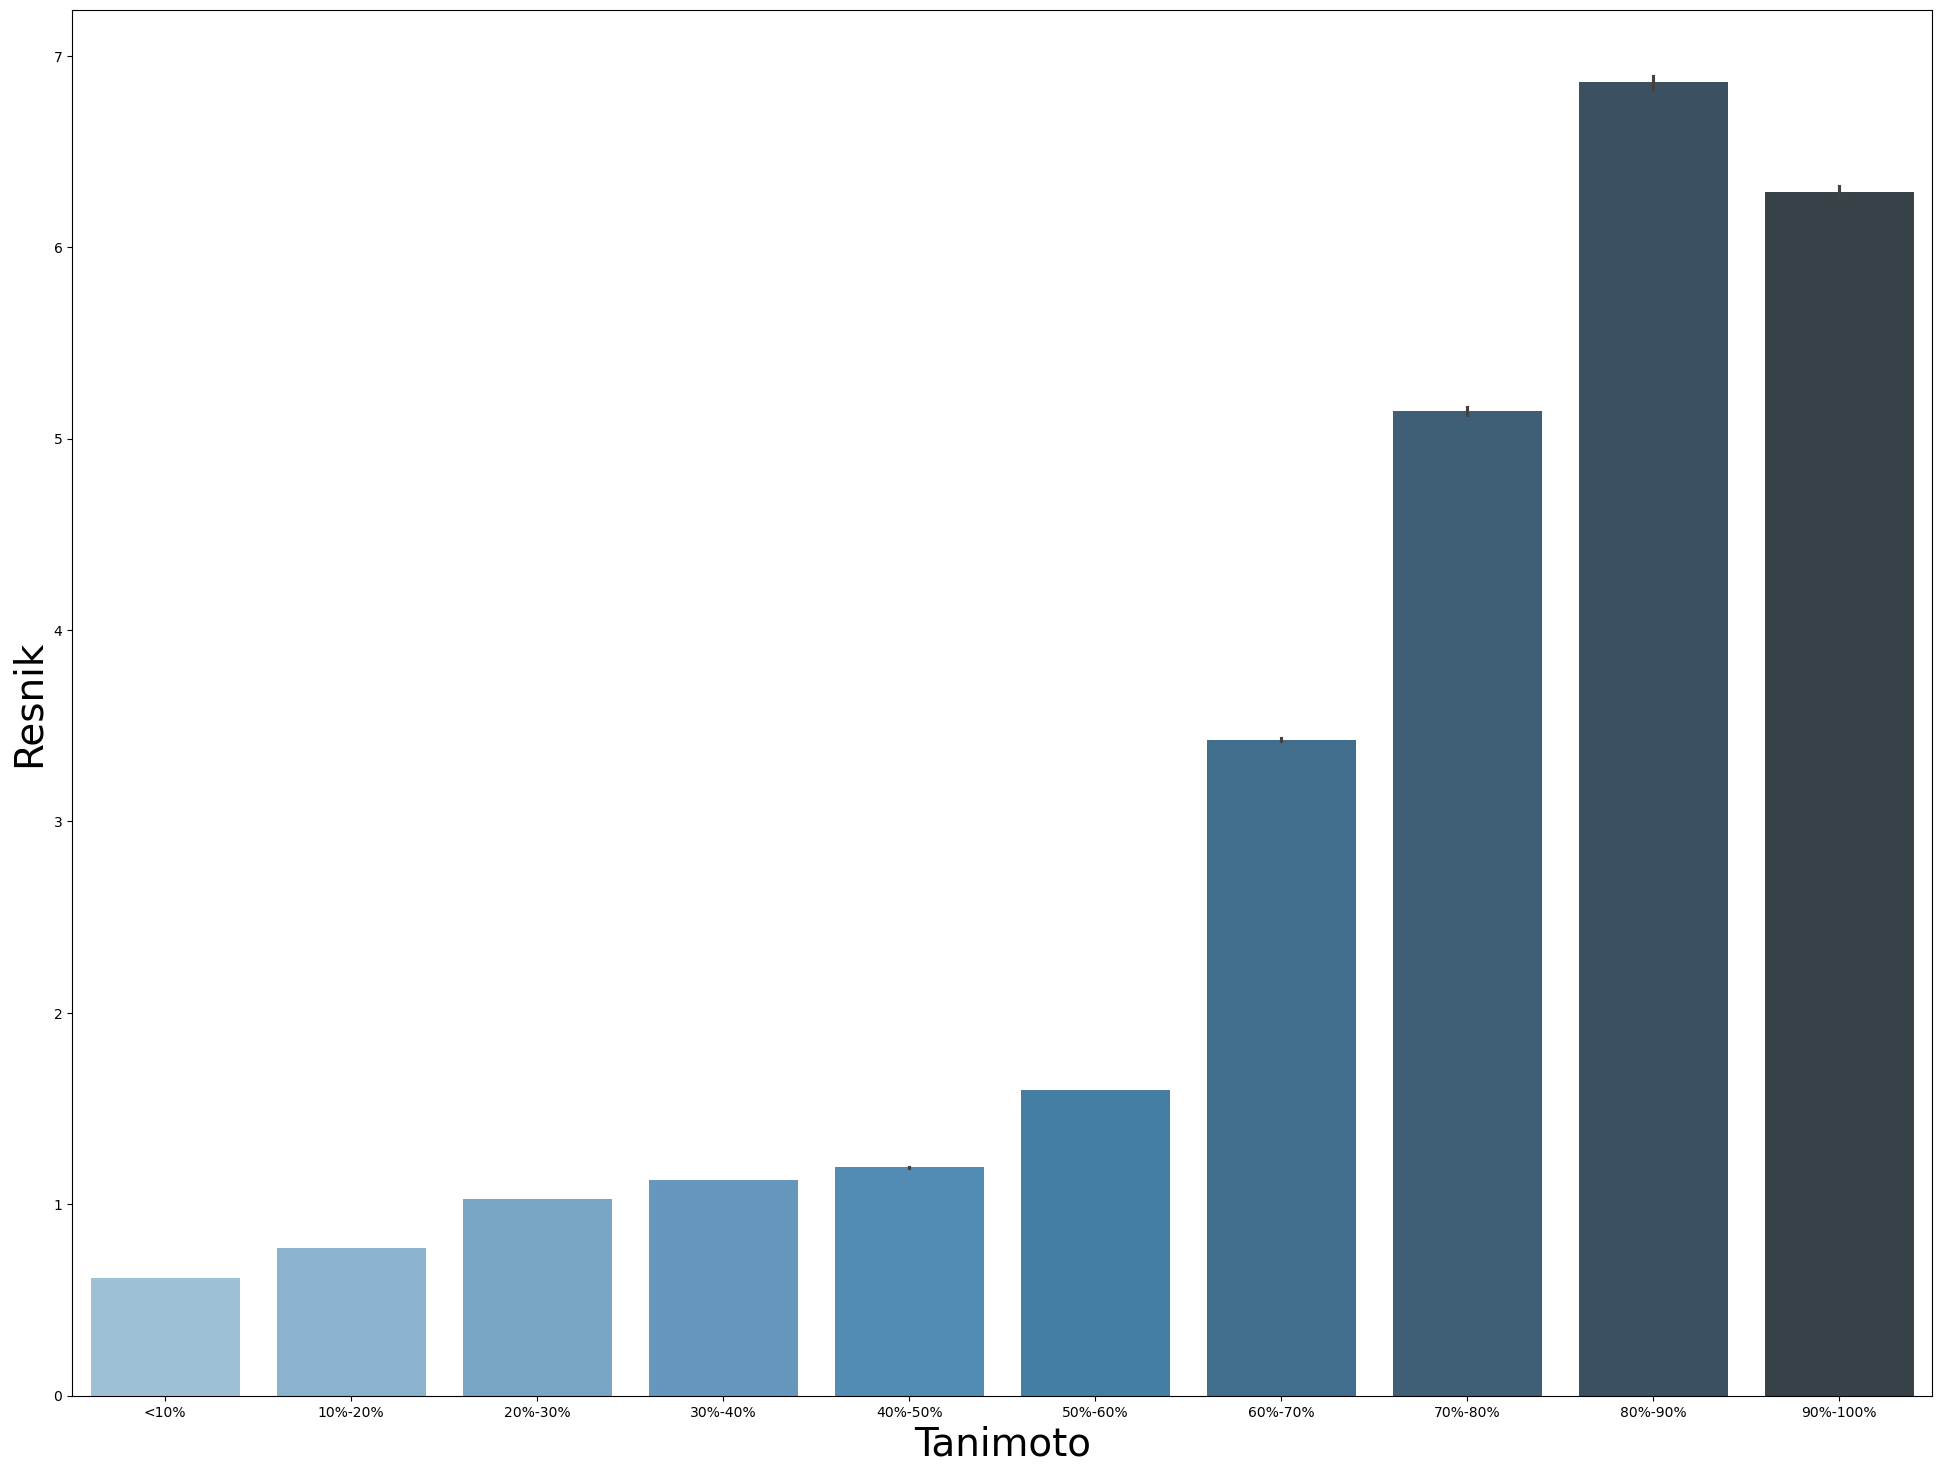

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Tanimoto", y="Resnik", data=Resnik_Tanimoto_df,errorbar='se',
                 palette="Blues_d")
#ax.set_yscale("log")
ax.set_ylabel("Resnik",fontsize=28)
ax.set_xlabel("Tanimoto",fontsize=28)
plt.savefig('output/Figures/SF2I_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()



In [25]:
 
# Combine all lists into a list of lists
resnik_lists = [resnik_list_1, resnik_list_2, resnik_list_3, resnik_list_4,
                resnik_list_5, resnik_list_6, resnik_list_7, resnik_list_8,
                resnik_list_9, resnik_list_10]

# Define bin labels
bin_labels = [f"{i*10-10}-{i*10}%" for i in range(1, 11)]

# Create summary
summary_data = []
for label, lst in zip(bin_labels, resnik_lists):
    arr = np.array(lst)
    count = len(arr)
    mean = np.mean(arr) if count > 0 else np.nan
    se = np.std(arr, ddof=1)/np.sqrt(count) if count > 1 else np.nan
    summary_data.append([label, count, mean, se])

df_SF3I_summary = pd.DataFrame(summary_data, columns=["Tanimoto bin", "Count", "Mean Resnik", "SE Resnik"])

with pd.ExcelWriter("output/Source_Data_exposurome.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_SF3I_summary.to_excel(writer, sheet_name="SF3I", index=False)

In [19]:
#Let's import the genetic overlap JI
    
with open('intermediate/parenthood_overlap_pairs_dictio.pickle', 'rb') as handle:
    parenthood_overlap_pairs_dictio = pk.load(handle)
    
with open('intermediate/wo_parentalhood_gene_overlap.pickle', 'rb') as handle:
    wo_parenthood_overlap_pairs_dictio = pk.load(handle)

In [20]:
#Let's merge them together

tot_overlap={**wo_parenthood_overlap_pairs_dictio, **parenthood_overlap_pairs_dictio}

In [21]:
tot_overlap_list=[]
tot_resnik_list=[]
for pair,val in tot_overlap.items():
    tot_overlap_list.append(val)
    tot_resnik_list.append(tot_resnik[pair])

In [22]:
import scipy  
from scipy import stats
print(scipy.stats.pearsonr(tot_overlap_list,tot_resnik_list))  # Pearson's r
print(scipy.stats.spearmanr(tot_overlap_list,tot_resnik_list)) # Spearman's rho

PearsonRResult(statistic=0.027833858618420127, pvalue=0.0)
SignificanceResult(statistic=0.005254834209326672, pvalue=1.9592914711278474e-295)


In [ ]:
#Correlation coefficient between JI and Resnik score considering all exposures
from matplotlib.pyplot import figure
import scipy  
from scipy import stats
fig, ax = plt.subplots(figsize=(15,15))

slope, intercept, r, p, stderr = scipy.stats.linregress(tot_overlap_list, tot_resnik_list)

ax.plot(tot_overlap_list,tot_resnik_list, linewidth=0, marker='s', c='k',label='Exposure pair', alpha=0.4)
#y=[]
#for i in tot_overlap_list:
#    g=(intercept + slope * i)
#    y.append(g)
#line = "Regression line" 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#ax.plot(tot_overlap_list, y, label=line,linewidth=5)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 
#plt.title('Total correlation between Resnik and Genetic overlap' )
ax.legend(facecolor='white',fontsize=36)
import matplotlib
matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",
        "\\usepackage[T1]{fontenc}"]
})

#plt.savefig('output/Figures/SF4B.pdf',format='pdf',dpi=300, bbox_inches = "tight")


#plt.show()

In [24]:

# Convert to array for convenience
tot_overlap_array = np.array(tot_overlap_list)
tot_resnik_array = np.array(tot_resnik_list)

# Stack the two arrays as columns
scatter_data = np.column_stack((tot_overlap_array, tot_resnik_array))

# Save to a tab-separated text file
np.savetxt("output/SourceData_SF3J.txt", scatter_data, 
           delimiter="\t", header="Jaccard_index\tResnik_score", comments='', fmt='%.6f')




In [5]:
tanimoto_list=[]
overlap_list=[]
for k,v in chem_tanimoto_dict.items():
    tanimoto_list.append(v)
    overlap_list.append(tot_overlap[k])

In [6]:
import scipy  
from scipy import stats
print(scipy.stats.pearsonr(tanimoto_list,overlap_list))  # Pearson's r
print(scipy.stats.spearmanr(tanimoto_list,overlap_list)) # Spearman's rho

PearsonRResult(statistic=0.03580407252724335, pvalue=0.0)
SignificanceResult(statistic=-0.0008804046410183891, pvalue=1.2971655228677776e-05)
